In [234]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [235]:
HOUSING_PATH_FULL='C:/Users/samys/PycharmProjects/HousingPrices/data/Melbourne_housing_FULL.csv'

def load_housing_data(housing_path=HOUSING_PATH_FULL):
    return pd.read_csv(housing_path)

In [236]:
loaded_data = load_housing_data()
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [237]:
train_val_set = loaded_data.dropna(subset=['Price'])
final_test = loaded_data[loaded_data['Price'].isna()]

new_column_names = {'Lattitude': 'Latitude', 'Longtitude': 'Longitude'}
melb_data = train_val_set.rename(columns=new_column_names)

PRICE_MEAN = melb_data['Price'].mean()
print(PRICE_MEAN)

1050173.344955408


In [238]:
def remove_outliers_iqr_all(df, columns, factor=2):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        outliers = df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)]
        print(f"Number of outliers in {col}: {len(outliers)}")
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

In [239]:
cols = ['Price', 'Rooms', 'Bedroom2', 'Bathroom']
melb_data = remove_outliers_iqr_all(melb_data, cols)

Number of outliers in Price: 784
Number of outliers in Rooms: 6
Number of outliers in Bedroom2: 5
Number of outliers in Bathroom: 27


In [240]:
train_set, test_set = train_test_split(melb_data, test_size=0.2, random_state=42)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16089 entries, 21012 to 25945
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         16089 non-null  object 
 1   Address        16089 non-null  object 
 2   Rooms          16089 non-null  int64  
 3   Type           16089 non-null  object 
 4   Price          16089 non-null  float64
 5   Method         16089 non-null  object 
 6   SellerG        16089 non-null  object 
 7   Date           16089 non-null  object 
 8   Distance       16089 non-null  float64
 9   Postcode       16089 non-null  float64
 10  Bedroom2       16089 non-null  float64
 11  Bathroom       16089 non-null  float64
 12  Car            15780 non-null  float64
 13  Landsize       13905 non-null  float64
 14  BuildingArea   8205 non-null   float64
 15  YearBuilt      9321 non-null   float64
 16  CouncilArea    16089 non-null  object 
 17  Latitude       16070 non-null  float64
 18  Longitu

In [241]:
# train_set = remove_outliers_iqr_all(train_set, cols)


train_set['Price'] = np.log1p(train_set['Price'])
test_set['Price'] = np.log1p(test_set['Price'])


In [242]:
housing = train_set.copy()
numerical_features = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_set.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)


Numerical features: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Latitude', 'Longitude', 'Propertycount']
Categorical features: ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Postcode'}>],
       [<Axes: title={'center': 'Bedroom2'}>,
        <Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>],
       [<Axes: title={'center': 'Propertycount'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

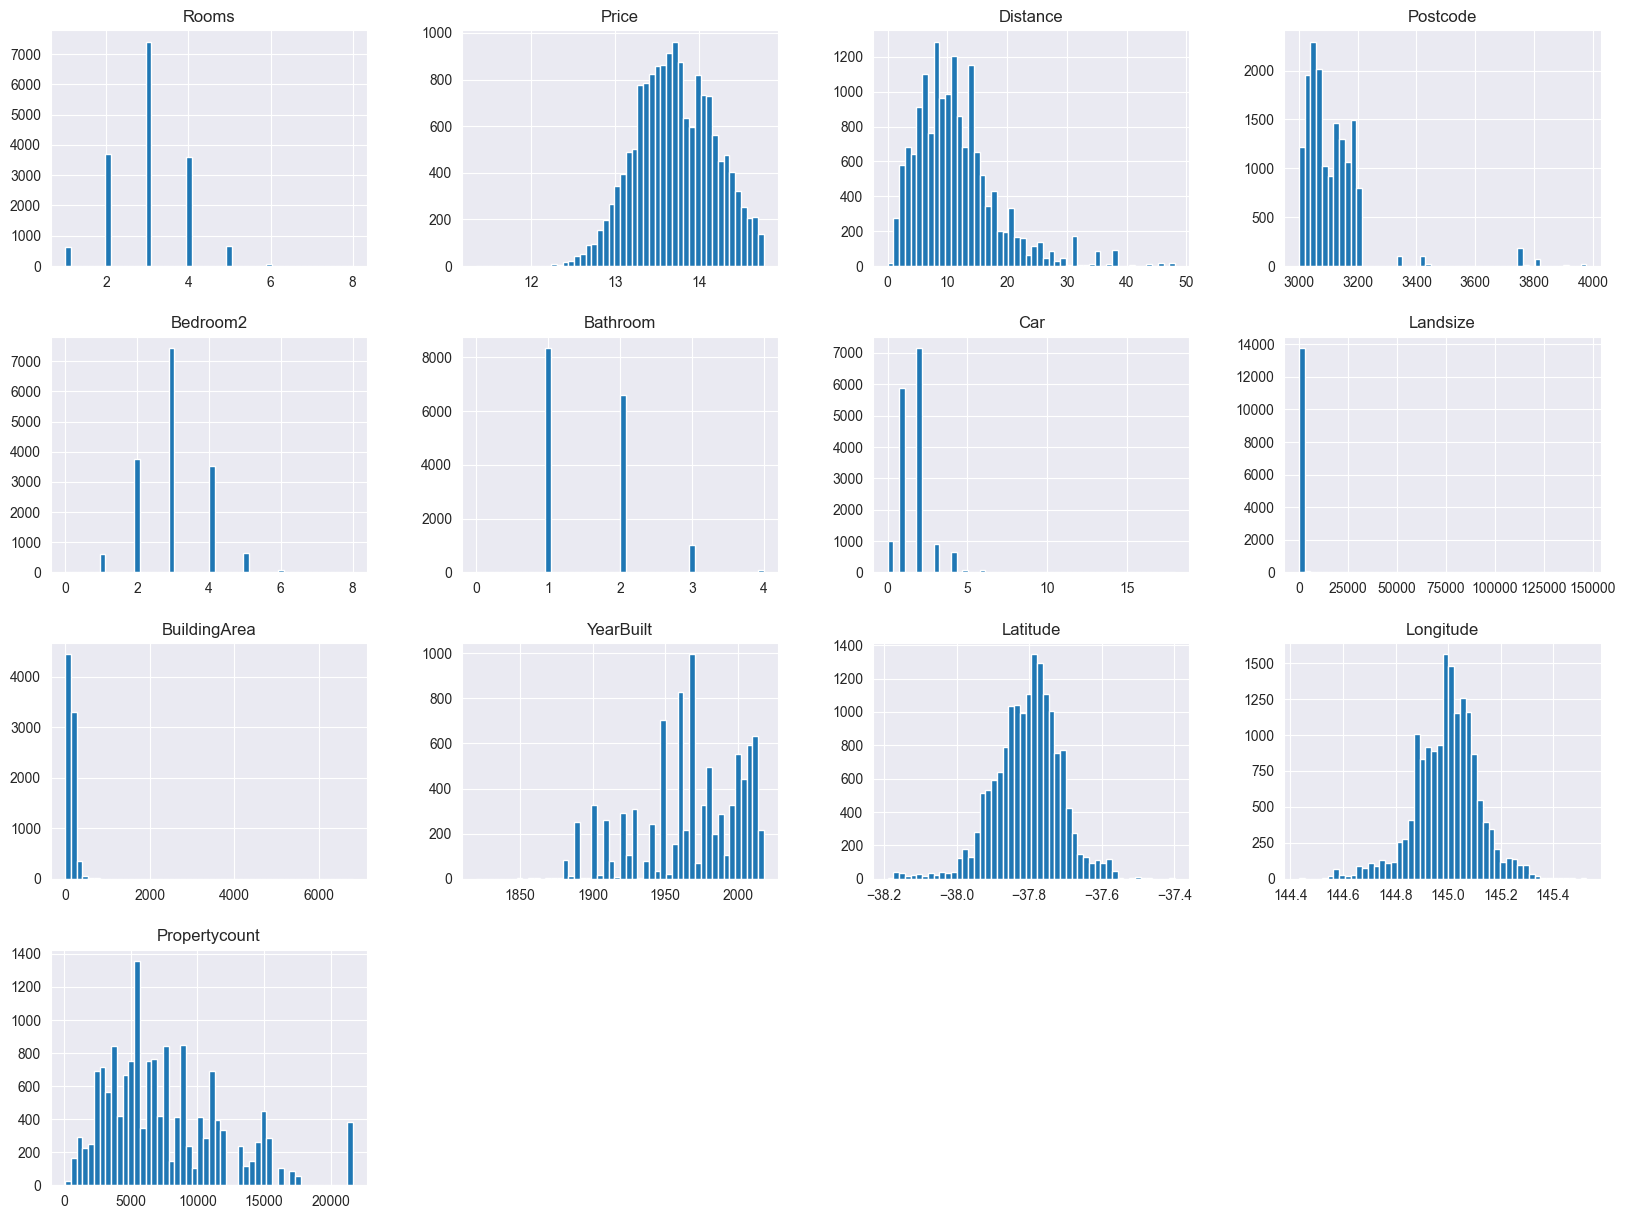

In [243]:
housing_num = housing[numerical_features]
housing.hist(bins=50, figsize=(20, 15))

In [244]:
corr_matrix = housing_num.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price            1.000000
Rooms            0.468017
Bedroom2         0.455506
Bathroom         0.357307
BuildingArea     0.281188
Longitude        0.262129
Car              0.180673
Landsize         0.031397
Postcode        -0.004181
Propertycount   -0.086392
Distance        -0.228504
Latitude        -0.233354
YearBuilt       -0.389043
Name: Price, dtype: float64

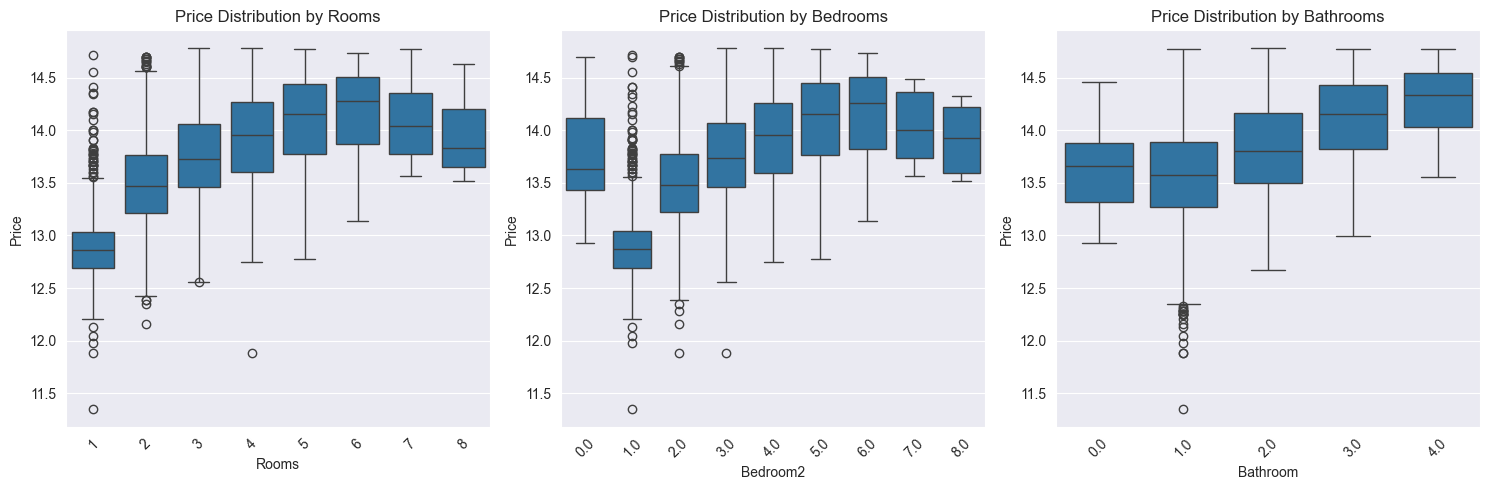

In [245]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Price vs Rooms
sns.boxplot(data=housing, x='Rooms', y='Price', ax=axes[0])
axes[0].set_title('Price Distribution by Rooms')
axes[0].tick_params(axis='x', rotation=45)

# Price vs Bedrooms
sns.boxplot(data=housing, x='Bedroom2', y='Price', ax=axes[1])
axes[1].set_title('Price Distribution by Bedrooms')
axes[1].tick_params(axis='x', rotation=45)

# Price vs Bathrooms
sns.boxplot(data=housing, x='Bathroom', y='Price', ax=axes[2])
axes[2].set_title('Price Distribution by Bathrooms')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [246]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16089 entries, 21012 to 25945
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         16089 non-null  object 
 1   Address        16089 non-null  object 
 2   Rooms          16089 non-null  int64  
 3   Type           16089 non-null  object 
 4   Price          16089 non-null  float64
 5   Method         16089 non-null  object 
 6   SellerG        16089 non-null  object 
 7   Date           16089 non-null  object 
 8   Distance       16089 non-null  float64
 9   Postcode       16089 non-null  float64
 10  Bedroom2       16089 non-null  float64
 11  Bathroom       16089 non-null  float64
 12  Car            15780 non-null  float64
 13  Landsize       13905 non-null  float64
 14  BuildingArea   8205 non-null   float64
 15  YearBuilt      9321 non-null   float64
 16  CouncilArea    16089 non-null  object 
 17  Latitude       16070 non-null  float64
 18  Longitu

In [247]:

drop_cols = ["BuildingArea", "YearBuilt", "Postcode", "Latitude", "Longitude", "Address"]
housing_clean = housing.drop(columns=drop_cols)

important_dropna_cols = ["Distance", "CouncilArea", "Regionname"]
housing_clean = housing_clean.dropna(subset=important_dropna_cols)

median_impute_cols = ["Bedroom2", "Bathroom", "Car", "Landsize"]
mean_impute_cols = ["Propertycount"]

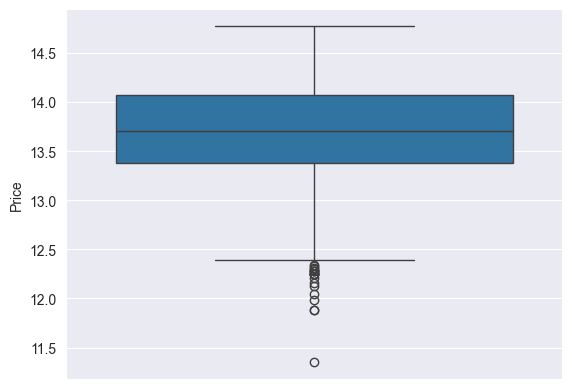

In [248]:

sns.boxplot(data=housing_clean, y='Price')
plt.show()

In [249]:

median_imputer = SimpleImputer(strategy="median")
mean_imputer = SimpleImputer(strategy="mean")

imputer_transform = ColumnTransformer(transformers=[
    ("median_imputer", median_imputer, median_impute_cols),
    ("mean_imputer", mean_imputer, mean_impute_cols)
],
    remainder="passthrough",
    verbose_feature_names_out=False)

numerical_cols = housing_clean.select_dtypes(include=['int64', 'float64']).columns.drop('Price').tolist()
categorical_cols = housing_clean.drop(columns=numerical_cols + ['Price']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('imputer_transform', imputer_transform),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])


Numerical columns: ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']
Categorical columns: ['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


In [250]:
X_train = housing_clean.drop(columns=["Price"])
Y_train = housing_clean["Price"]

X_train_transformed = pipeline.fit_transform(X_train)


In [251]:

test_set_clean = test_set.drop(columns=drop_cols)
test_set_clean = test_set_clean.dropna(subset=important_dropna_cols)


X_test = test_set_clean.drop(columns=["Price"])
Y_test = test_set_clean["Price"]

X_test_transformed = pipeline.transform(test_set_clean)


In [252]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [253]:

models = {
    # 'Linear': LinearRegression(),
    # 'Ridge': Ridge(alpha=1.0),
    # 'Lasso': Lasso(alpha=0.01),
    # 'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    # 'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    # 'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    # 'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}




In [254]:
preds = {}

for name, model in models.items():
    model.fit(X_train_transformed, Y_train)
    pred = model.predict(X_test_transformed)
    preds[name] = pred


In [255]:
def print_error(name, y_pred_log):
    print('---------------------------------------------------------\n')
    print(f'Model: {name}')
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(Y_test)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Выводим результаты
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R²: {r2}")

In [256]:
for name, pred in preds.items():
    print_error(name, pred)

---------------------------------------------------------

Model: CatBoost
Mean Absolute Error (MAE): 138860.2596922158
Mean Squared Error (MSE): 41588595143.38387
Root Mean Squared Error (RMSE): 203932.82017219267
R²: 0.8233105474886284


In [257]:

# Create scorers for multiple metrics
rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Set up k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for different metrics
rmse_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                              scoring=rmse_scorer, cv=kf)
r2_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                            scoring=r2_scorer, cv=kf)
mae_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                             scoring='neg_mean_absolute_error', cv=kf)


print("Cross-validation results:")
print(f"RMSE scores: {-rmse_scores}")  # Negative because scorer is negative for minimization
print(f"Average RMSE: {-rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")
print(f"\nR² scores: {r2_scores}")
print(f"Average MAE: {r2_scores.mean():.4f} (+/- {r2_scores.std() * 2:.4f})")
print(f"\nMAE scores: {mae_scores}")
print(f"Average MAE: {mae_scores.mean():.4f} (+/- {mae_scores.std() * 2:.4f})")


Cross-validation results:
RMSE scores: [200355.21667234 202411.36151888 204208.73489036 207551.77887667
 198105.53159063]
Average RMSE: 202526.5247 (+/- 6471.8487)

R² scores: [0.82168515 0.8260869  0.81829561 0.81885579 0.8281477 ]
Average MAE: 0.8226 (+/- 0.0078)

MAE scores: [-139072.48798521 -142722.26619836 -142008.57203982 -143133.07781142
 -137008.01170987]
Average MAE: -140788.8831 (+/- 4729.6394)


In [258]:
good_model = models['CatBoost']

random_house = test_set_clean.sample(n=1)

display(random_house)

random_house_X = random_house.drop(columns=["Price"])
random_house_Y = random_house["Price"]

random_house_transformed = pipeline.transform(random_house_X)
random_prediction = good_model.predict(random_house_transformed)

price = random_house_Y.values[0]
print(f'True value : {np.expm1(price)}')
print(f'Predicted value : {np.expm1(random_prediction[0])}')


,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Bedroom2,Bathroom,Car,Landsize,CouncilArea,Regionname,Propertycount
25082,Glen Iris,4,h,14.699279,S,Kay,21/10/2017,7.3,4.0,2.0,2.0,638.0,Boroondara City Council,Southern Metropolitan,10412.0


True value : 2420000.0
Predicted value : 2136283.457746473


In [259]:
from scipy.stats import uniform, randint

def RandomSearchFit():
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    param_dist = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'iterations': [200, 500, 1000],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }

    param_random = {
        'iterations': randint(500, 1500),                    # с расчетом на раннюю остановку
        'learning_rate': uniform(0.01, 0.3),                 # от 0.01 до 0.31
        'depth': randint(4, 11),                             # от 4 до 10
        'l2_leaf_reg': uniform(1, 9),                        # от 1 до 10
        'bagging_temperature': uniform(0, 1.5),              # от 0 до 1.5
        'random_strength': uniform(0, 10),                   # от 0 до 10
        'rsm': uniform(0.5, 0.5),                            # от 0.5 до 1.0
        'subsample': uniform(0.6, 0.4),                      # от 0.6 до 1.0
        'scale_pos_weight': uniform(0.5, 4.5),               # от 0.5 до 5.0 (только для бинарной классификации)
    }


    cat = CatBoostRegressor(verbose=0, random_state=42)

    search = RandomizedSearchCV(
        cat,
        param_distributions=param_dist,
        n_iter=20,
        scoring=rmse_scorer,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train_transformed, Y_train)

    print("Лучшие параметры:", search.best_params_)
    print("Лучшее значение RMSE (на CV):", -search.best_score_)


    best_model = search.best_estimator_

    y_pred_log = best_model.predict(X_test_transformed)

    print_error("CatBoost (поиск по сетке)", y_pred_log)


In [260]:
RandomSearchFit()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 10}
Лучшее значение RMSE (на CV): 0.030593790887051425
---------------------------------------------------------

Model: CatBoost (поиск по сетке)
Mean Absolute Error (MAE): 136775.859459888
Mean Squared Error (MSE): 40662413449.08909
Root Mean Squared Error (RMSE): 201649.23369328506
R²: 0.8272454372324825


In [261]:

def GridSearchFit():
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cat_grid = CatBoostRegressor(verbose=0, random_state=42)

    param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [0, 1, 5, 10],
    'rsm': [0.5, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3, 5]  # применимо только при дисбалансе классов в бинарной классификации
    }


    param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 300, 500]
    }

    grid_search = GridSearchCV(
        estimator=cat_grid,
        param_grid=param_grid,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1
    )

    grid_search.fit(X_train_transformed, Y_train)
    print("Лучшая комбинация гиперпараметров:")
    print(grid_search.best_params_)

    print("\nЛучший (наименьший) RMSE (по CV):")
    print(f"{-grid_search.best_score_:.4f}")
    best_model = grid_search.best_estimator_

    grid_predict = best_model.predict(X_test_transformed)

    print_error("GridSearch CatBoost (поиск по сетке)", grid_predict)

In [262]:
GridSearchFit()

Лучшая комбинация гиперпараметров:
{'depth': 8, 'iterations': 500, 'learning_rate': 0.1}

Лучший (наименьший) RMSE (по CV):
0.1749
---------------------------------------------------------

Model: GridSearch CatBoost (поиск по сетке)
Mean Absolute Error (MAE): 137952.47112679208
Mean Squared Error (MSE): 41163796666.27304
Root Mean Squared Error (RMSE): 202888.63119029868
R²: 0.825115306944667
